# MNIST by SNN

## 1. Pre-process

### 1.1. Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from PIL import Image
import torchvision.transforms as transforms

import norse

import os
import os.path as osp

ImportError: cannot import name 'QuantStub' from 'torch.ao.quantization' (/usr/lib/python3.10/site-packages/torch/ao/quantization/__init__.py)

### 1.2. Load Data

We need below data files in current notebook's directory.

* `train_data.npz`
* `train_data_rot.npz`
* `val_data.npz`

If not, below code raises error!

In [5]:
# Check Data
files = [f for f in os.listdir('./') if osp.isfile(osp.join('./', f))]

class DataPathError(Exception):
    def __str__(self):
        return "Data files are not in proper directory!"

datalist = [
    'train_data.npz',
    'train_data_rot.npz',
    'val_data.npz'
]

if not all(map(lambda data: data in files, datalist)):
    raise DataPathError()

In [6]:
# Unrotated train data
train_data, train_targets = list(
    np.load("train_data.npz").values()
)

# Rotated train data
rtrain_data, rtrain_targets = list(
    np.load("train_data_rot.npz").values()
)

# Rotated validation data
val_data, val_targets = list(
    np.load("val_data.npz").values()
)

In [34]:
train_dataset = np.array(list(zip(train_data, train_targets)))
rtrain_dataset = np.array(list(zip(rtrain_data, rtrain_targets)))
val_dataset = np.array(list(zip(val_data, val_targets)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify

In [14]:
gen_train_indices = lambda n: torch.randperm(len(train_dataset))[:n].tolist()

In [35]:
train_100 = train_dataset[gen_train_indices(100)]
train_500 = train_dataset[gen_train_indices(500)]
train_1000 = train_dataset[gen_train_indices(1000)]
train_5000 = train_dataset[gen_train_indices(5000)]
train_10000 = train_dataset[gen_train_indices(10000)]

In [36]:
batch_size = 100

train_loader = DataLoader(
    dataset=train_100,
    batch_size=batch_size,
    shuffle=True
)

# rtrain_loader = DataLoader(
#     dataset=rtrain_dataset,
#     batch_size=batch_size,
#     shuffle=True
# )

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
)

### 1.3. Encoding Data

7


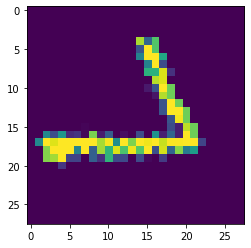

In [37]:
img, label = val_dataset[0]

plt.imshow(img[0])
print(label)

In [38]:
img.shape

(1, 28, 28)

In [54]:
temp = iter(val_loader)
test = next(temp)
test

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found object

#### 1.3.1. Constant Current Encoding

In [39]:
T = 32
cce = norse.torch.ConstantCurrentLIFEncoder(T)

cce_input = cce(torch.tensor(img[0]))
cce_spikes = cce_input.reshape(T, 28*28).to_sparse().coalesce()
t = cce_spikes.indices()[0]
n = cce_spikes.indices()[1]

plt.scatter(t, n, marker='|', color='black')
plt.xlabel('Time [ms]')
plt.ylabel('Input Unit')
plt.show()

AttributeError: module 'norse.torch' has no attribute 'ConstantCurrentLIFEncoder'

In [40]:
cce_input.shape

NameError: name 'cce_input' is not defined

#### 1.3.2. Rotation Encoding

In [41]:
def get_rot_mat(theta):
#     theta = [theta] if not isinstance(theta, list) else theta
    theta = theta if type(theta) == torch.Tensor else torch.tensor(theta)
    c = torch.cos(theta)
    s = torch.sin(theta)
    z = torch.zeros_like(theta)
    R1 = torch.stack([c, -s, z], dim=1)
    R2 = torch.stack([s, c, z], dim=1)
    R = torch.stack([R1, R2], dim=1)
    return R # shape = [len(theta), 2, 3]

def rot_mnist(x, theta):
    img = torch.tensor(x).reshape(-1, 28, 28).repeat(len(theta), 1, 1) # [batch * len(theta), 28, 28]
    img = img.reshape(-1, 1, 28, 28)                        # [batch * len(theta), 1, 28, 28]
    rot_mat = get_rot_mat(theta).repeat(x.shape[0],1,1) # [batch * len(theta), 2, 3]
    grid = F.affine_grid(rot_mat, img.size(), align_corners=False)
    y = F.grid_sample(img, grid, align_corners=False)
    return y.reshape(len(theta), x.shape[0], 1, 28, 28) # [len(theta), batch, 1, 28, 28]

In [42]:
img, label = val_dataset[0]
img_rotated = rot_mnist(img, torch.arange(0, 2*np.pi, 2*np.pi/6))
img_rotated.shape

torch.Size([6, 1, 1, 28, 28])

In [43]:
get_rot_mat(torch.arange(0, 2*np.pi, 2*np.pi/6)).shape

torch.Size([6, 2, 3])

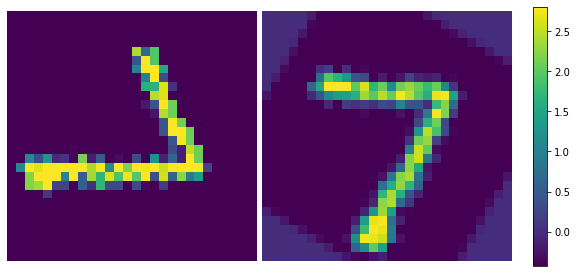

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    p = ax.imshow(img_rotated[i,0,0])

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

cb_ax = fig.add_axes([0.83, 0.2, 0.02, 0.6])
cbar = fig.colorbar(p, cax=cb_ax)
plt.show()

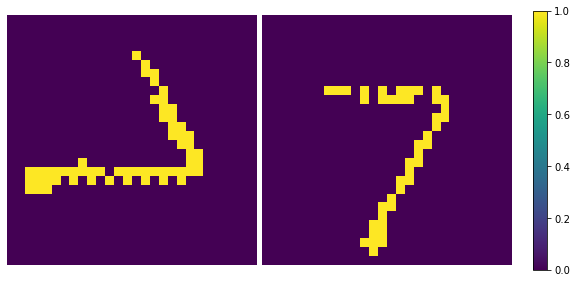

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    p = ax.imshow(img_rotated[i,0,0] > 2.0)

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

cb_ax = fig.add_axes([0.83, 0.2, 0.02, 0.6])
cbar = fig.colorbar(p, cax=cb_ax)
plt.show()

In [46]:
example_spike = (img_rotated > 2.0).type(torch.float).reshape(-1, 28*28).to_sparse().coalesce()

In [47]:
example_spike.indices().shape

torch.Size([2, 278])

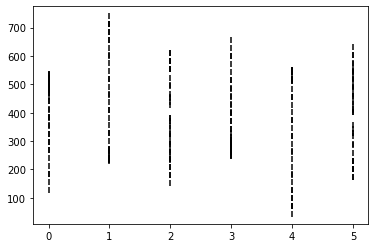

In [48]:
t = example_spike.indices()[0]
n = example_spike.indices()[1]

plt.scatter(t, n, marker='|', color='black')
plt.show()

In [49]:
def binarize(mnist_img, th=2.0):
    return (mnist_img > th).type(torch.float)

In [50]:
binarize(img_rotated).shape

torch.Size([6, 1, 1, 28, 28])

In [53]:
for d in val_loader:
    di, dl = d
    print(di)
    print(binarize(di).shape)
    break

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found object

In [21]:
def rotation_mnist_encoding(x, T=32):
    with torch.no_grad():
        thetas = torch.arange(0, 4*np.pi, 4*np.pi/T)
        return binarize(rot_mnist(x, thetas))

In [22]:
results = rotation_mnist_encoding(img)

In [23]:
img.shape

(1, 28, 28)

In [24]:
results.shape

torch.Size([32, 1, 1, 28, 28])

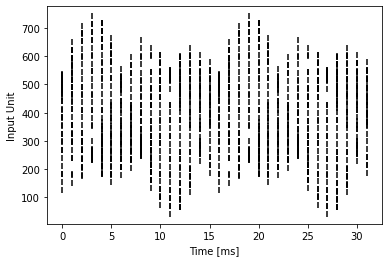

In [25]:
spikes = results.reshape(-1, 28*28).to_sparse().coalesce()

t = spikes.indices()[0]
n = spikes.indices()[1]

plt.scatter(t, n, marker='|', color='black')
plt.xlabel('Time [ms]')
plt.ylabel('Input Unit')
plt.show()

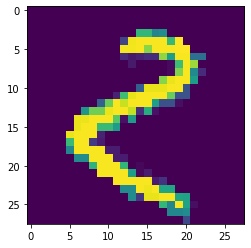

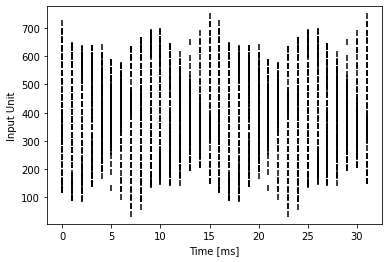

2


In [26]:
img, label = val_dataset[1]
plt.imshow(img[0])
plt.show()
spikes = rotation_mnist_encoding(img).reshape(-1, 28*28).to_sparse().coalesce()
t = spikes.indices()[0]
n = spikes.indices()[1]

plt.scatter(t, n, marker='|', color='black')
plt.xlabel('Time [ms]')
plt.ylabel('Input Unit')
plt.show()

print(label)

In [27]:
for data in val_loader:
    img, lab = data
    print(img.shape)
    print(rotation_mnist_encoding(img).shape)
    break

torch.Size([256, 1, 28, 28])
torch.Size([32, 256, 1, 28, 28])


/tmp/ipykernel_23165/4013761888.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(x).reshape(-1, 28, 28).repeat(len(theta), 1, 1) # [batch * len(theta), 28, 28]


## 2. Learning

### 2.1. LIFRecurrentCell

In [28]:
from norse.torch import LIFParameters, LIFState
from norse.torch.module.lif import LIFCell, LIFRecurrentCell
from norse.torch import LICell, LIState
from typing import NamedTuple

In [29]:
class SNNState(NamedTuple):
    lif0 : LIFState
    readout : LIState


class SNN(torch.nn.Module):
    def __init__(self, input_features, hidden_features, output_features, record=False, dt=0.001):
        super(SNN, self).__init__()
        self.l1 = LIFRecurrentCell(
            input_features,
            hidden_features,
            p=LIFParameters(alpha=100, v_th=torch.tensor(2.)),
            dt=dt                     
        )
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record
        

        
    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = so = None
        voltages = []

        if self.record:
            self.recording = SNNState(
                LIFState(
                    z = torch.zeros(seq_length, batch_size, self.hidden_features),
                    v = torch.zeros(seq_length, batch_size, self.hidden_features),
                    i = torch.zeros(seq_length, batch_size, self.hidden_features)
                ),
                LIState(
                    v = torch.zeros(seq_length, batch_size, self.output_features),
                    i = torch.zeros(seq_length, batch_size, self.output_features)
                )
            )

        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            if self.record:
                self.recording.lif0.z[ts,:] = s1.z
                self.recording.lif0.v[ts,:] = s1.v
                self.recording.lif0.i[ts,:] = s1.i
                self.recording.readout.v[ts,:] = so.v
                self.recording.readout.i[ts,:] = so.i
            voltages += [vo]

        return torch.stack(voltages)

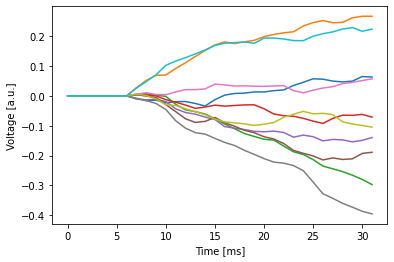

In [30]:
example_snn = SNN(28*28, 100, 10, record=True, dt=0.001)
img, label = val_dataset[1]
example_readout_voltages = example_snn(rotation_mnist_encoding(img))
voltages = example_readout_voltages.reshape(-1, 10).detach().numpy()
plt.plot(voltages)
plt.ylabel('Voltage [a.u.]')
plt.xlabel('Time [ms]')
plt.show()

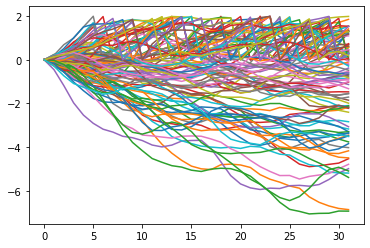

In [31]:
plt.plot(example_snn.recording.lif0.v.reshape(-1, 100).detach().numpy())
plt.show()

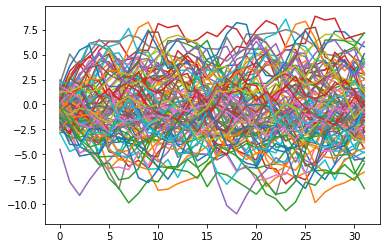

In [32]:
plt.plot(example_snn.recording.lif0.i.squeeze(1).detach().numpy())
plt.show()

### 2.2. Decoder

In [33]:
def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

def decode_last(x):
    x = x[-1]
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

### 2.3. Define Main Network

In [34]:
class Model(torch.nn.Module):
    def __init__(self, encoder, snn, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

In [35]:
T = 32
LR = 0.002
INPUT_FEATURES = 28*28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 10
DEVICE = 'cpu'
# if torch.cuda.is_available():
#     DEVICE = torch.device("cuda")
# else:
#     DEVICE = torch.device("cpu")

model = Model(
#     encoder=ConstantCurrentLIFEncoder(
#       seq_length=T,
#     ),
    encoder = rotation_mnist_encoding,
    snn=SNN(
      input_features=INPUT_FEATURES,
      hidden_features=HIDDEN_FEATURES,
      output_features=OUTPUT_FEATURES
    ),
    decoder=decode
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=784, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(2.), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=100, out_features=10, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

In [36]:
from tqdm.notebook import tqdm, trange

EPOCHS = 20  # Increase this number for better performance 

def train(model, device, train_loader, optimizer, epoch, max_epochs):
    model.train()
    losses = []

    for (data, target) in tqdm(train_loader, leave=False):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss

In [37]:
def validate(model, device, val_loader, epoch):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)

    accuracy = 100.0 * correct / len(val_loader.dataset)

    return val_loss, accuracy

In [38]:
training_losses = []
mean_losses = []
val_losses = []
accuracies = []

torch.autograd.set_detect_anomaly(True)

for epoch in trange(EPOCHS):
    training_loss, mean_loss = train(model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS)
    val_loss, accuracy = validate(model, DEVICE, val_loader, epoch)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    val_losses.append(val_loss)
    accuracies.append(accuracy)
    print(f"val loss: {val_loss:.4f}, val acc: {accuracy:.2f}%")

print(f"final accuracy: {accuracies[-1]}")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

/tmp/ipykernel_23165/4013761888.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(x).reshape(-1, 28, 28).repeat(len(theta), 1, 1) # [batch * len(theta), 28, 28]


val loss: 1.2310, val acc: 57.22%


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 1.0086, val acc: 67.13%


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 0.9246, val acc: 69.77%


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 0.8464, val acc: 72.70%


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 0.7942, val acc: 73.98%


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 0.7545, val acc: 75.42%


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 0.7333, val acc: 76.47%


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 0.7153, val acc: 76.74%


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 0.6834, val acc: 77.93%


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 0.6938, val acc: 77.59%


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 0.6555, val acc: 78.66%


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 0.6514, val acc: 78.54%


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 0.6335, val acc: 79.64%


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 0.6349, val acc: 79.51%


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 0.6229, val acc: 79.70%


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 0.6139, val acc: 79.97%


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 0.6012, val acc: 80.59%


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 0.6036, val acc: 80.52%


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 0.5909, val acc: 80.62%


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 0.5835, val acc: 81.26%
final accuracy: 81.26


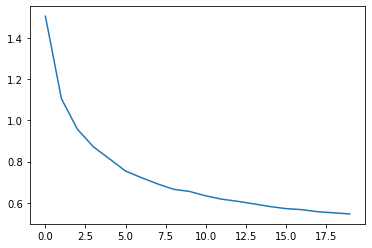

In [39]:
plt.plot(mean_losses)

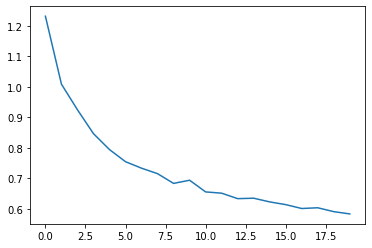

In [40]:
plt.plot(val_losses)

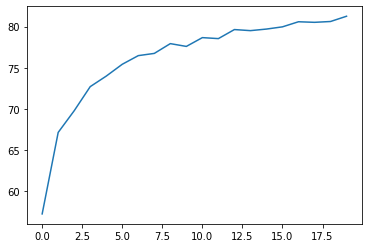

In [41]:
plt.plot(accuracies)

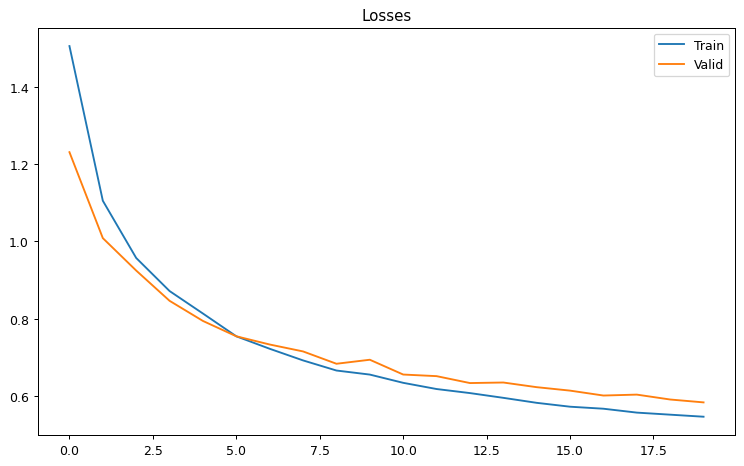

In [46]:
plt.figure(figsize=(10, 6), dpi=90)
plt.plot(mean_losses, label="Train")
plt.plot(val_losses, label="Valid")
plt.title("Losses")
plt.legend()
plt.show()

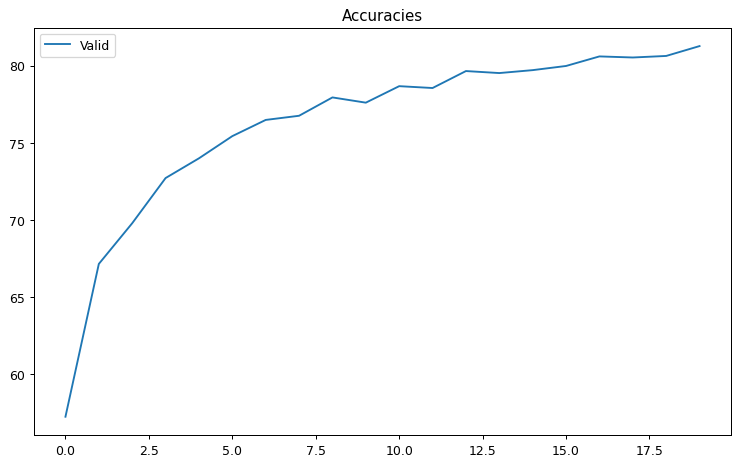

In [47]:
plt.figure(figsize=(10, 6), dpi=90)
plt.plot(accuracies, label="Valid")
plt.title("Accuracies")
plt.legend()
plt.show()